# Spacy model for Bosnian language - pipeline demo

This is a custom tokenizer and NLP pipeline for Bosnian using the Croatian hr_core_news_sm model as a base. It uses Croatian model annotations, defines a minimal Bosnian language class, converts sentences into a custom CoNLL-like format (with some extra columns like NER info).

Note: The code in this notebook is used for demo purposes. The code that was used for the development of the model is contained in the [preprocessing_and_training_code folder](https://drive.google.com/drive/folders/1Hip_4TqXkdH2ZVOYc-TwZDMJrKVNNHgr) of this drive



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Croatian SpaCy model

The first performed step is to download the Croatian model from Spacy.

In [2]:
!python -m spacy download hr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 5.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('hr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


This model is then loaded and a demonstration of it's usage is given on an example sentence.

In [3]:
import spacy
from spacy.lang.hr.examples import sentences

nlp = spacy.load("hr_core_news_sm")
doc = nlp("Predsjednik Federacije Bosne i Hercegovine održao je govor u Sarajevu.")
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.ent_iob_, token.ent_type_)

for ent in doc.ents:
    print(f"{ent.text:<30} {ent.label_}")

Predsjednik Federacije Bosne i Hercegovine održao je govor u Sarajevu.
Predsjednik NOUN nsubj O 
Federacije NOUN nmod B LOC
Bosne PROPN compound I LOC
i CCONJ flat I LOC
Hercegovine PROPN flat I LOC
održao VERB ROOT O 
je AUX aux O 
govor NOUN obj O 
u ADP case O 
Sarajevu PROPN obl B LOC
. PUNCT punct O 
Federacije Bosne i Hercegovine LOC
Sarajevu                       LOC


## Data preprocesing, Using the Croatian model for converting sentences to CoNLL and Spacy formats

To build a custom SpaCy pipeline for the Bosnian language it is useful to use the Croatian pipeline as a reference. The croatian dataset used for training of the model is served in the CoNLL format, so we try to demonstrate the conversion of some example sentences to this format.

For this purpose a `to_conllu` function is defined which accepts a SpaCy `Doc` object and `sent_id` which serves as an identifier of the sentence in the output.

The first step in the conversion is to add metadata comments. After that a loop is defined to iterate over each token in the processed Doc and extract core  token info of form, lemma, POS tag, language-specific POS tag and morphological features of the word.

Then the process of dependecy parsing is performed, and extra columns are added which isn't core info

Finally the line is built and returned from the function.

Example: If a conj verb (like posluje) has a right-side noun or phrase with a case (preposition) nearby, and it's currently attached to a non-local verb, reattach it to the conj verb.

The following is a demonstration of the preprocessing, due to resource constraints actual preprocessing was performed locally, which is visible in the preprocessing_and_training_code folder of this drive

In [ ]:
import spacy
import os
import re

# Load Croatian model
try:
    nlp = spacy.load("hr_core_news_sm")
    print("Croatian model loaded.")
except:
    nlp = spacy.blank("hr")
    print("Croatian model not found. Using blank fallback model.")

def fix_deprel(token):
    if token.dep_ == "nummod" and token.head.pos_ == "NOUN":
        return "nummod:gov"
    if token.dep_ == "ROOT":
        return "root"
    return token.dep_ if token.dep_ else "dep"

def find_head(token):
    return 0 if token.dep_ == "ROOT" else token.head.i + 1

def sanitize(value):
    return str(value).replace("\t", " ").replace("\n", " ").strip() or "_"

def to_conllu(doc, sent_id):
    lines = [f"# sent_id = {sent_id}", f"# text = {doc.text}"]
    for i, token in enumerate(doc, start=1):
        form = sanitize(token.text)
        lemma = sanitize(token.lemma_)
        upos = token.pos_ or "X"
        xpos = token.tag_ or "_"
        feats = sanitize(token.morph)
        head = find_head(token)
        deprel = fix_deprel(token)

        if token.ent_type_:
            if token.ent_iob_ == "B":
                ner = f"B-{token.ent_type_}"
            elif token.ent_iob_ == "I":
                ner = f"I-{token.ent_type_}"
            else:
                ner = "O"
        else:
            ner = "O"

        misc = [f"NER={ner}"]
        if token.ent_type_:
            misc.append("NamedEntity=Yes")
        if i < len(doc) and not token.whitespace_:
            misc.append("SpaceAfter=No")

        misc_str = "|".join(misc) if misc else "_"

        lines.append(f"{i}\t{form}\t{lemma}\t{upos}\t{xpos}\t{feats}\t{head}\t{deprel}\t_\t{misc_str}")

    lines.append("")
    return "\n".join(lines)

def extract_articles(text):
    articles = re.split(r"<\*{3,}>", text)
    cleaned_articles = []
    for art in articles:
        match = re.search(r"AUTOR\(I\):.*?\n\n(.+)", art.strip(), flags=re.DOTALL)
        if match:
            body = match.group(1).strip()
            cleaned_articles.append(body)
    return cleaned_articles

def process_and_append(input_path, output_path, file_index):
    with open(input_path, encoding="utf-8") as f:
        raw = f.read()

    articles = extract_articles(raw)
    conllu_blocks = []

    # Batch process for speed
    docs = list(nlp.pipe(articles, batch_size=16, n_process=4))

    for idx, doc in enumerate(docs):
        for i, sent in enumerate(doc.sents):
            sentence_doc = nlp(sent.text)
            conllu_blocks.append(to_conllu(sentence_doc, sent_id=f"file{file_index}_art{idx+1}_sent{i+1}"))

    with open(output_path, "a", encoding="utf-8") as out_f:
        out_f.write("\n".join(conllu_blocks))
        out_f.write("\n")

if __name__ == "__main__":
    input_folder = "/content/drive/MyDrive/VI_Projekat_Tim35/BS_TrainingData/Raw_data"
    output_file_path = "/content/drive/MyDrive/VI_Projekat_Tim35/BS_TrainingData/Processed_data/bstrainingdata.txt"

    for idx, filename in enumerate(os.listdir(input_folder)):
        if filename.endswith(".txt"):
            full_input_path = os.path.join(input_folder, filename)
            print(f"Processing {filename}...")
            process_and_append(full_input_path, output_file_path, idx + 1)

    print("All files processed and appended to:", output_file_path)

Croatian model loaded.
Processing /content/drive/MyDrive/VI_Projekat_Tim35/BS_TrainingData/Raw_data/sveuciliste_u_mostaru_pdf_scraping.txt...
All files processed and appended to: /content/drive/MyDrive/VI_Projekat_Tim35/BS_TrainingData/Processed_data/bstrainingdata.txt


In [ ]:
with open("/content/drive/MyDrive/VI_Projekat_Tim35/BS_TrainingData/Processed_data/bstrainingdata.txt", encoding="utf-8") as f:
    for lineno, line in enumerate(f, start=1):
        if line.startswith("#") or line.strip() == "":
            continue
        parts = line.rstrip("\n").split("\t")
        if len(parts) != 10:
            print(f"Line {lineno} has {len(parts)} columns: {line.strip()}")

In [ ]:
print(nlp.pipe_names)
print(nlp.pipeline)

['tok2vec', 'tagger', 'morphologizer', 'parser', 'lemmatizer', 'attribute_ruler', 'ner']
[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x7d0dbade1df0>), ('tagger', <spacy.pipeline.tagger.Tagger object at 0x7d0db226be90>), ('morphologizer', <spacy.pipeline.morphologizer.Morphologizer object at 0x7d0db226bf50>), ('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x7d0db2272ea0>), ('lemmatizer', <spacy.pipeline.edit_tree_lemmatizer.EditTreeLemmatizer object at 0x7d0db226b830>), ('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x7d0db2517850>), ('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x7d0db2273060>)]


Next the dataset in converted from .txt to .conllu format which is necsessary before using the data in the Spacy pipeline

In [ ]:
import spacy
from spacy.tokens import Doc, Span, Token
from spacy.training import Example
from spacy.tokens import DocBin
import os

nlp = spacy.blank("hr")

def read_conllu_sentences(file_path):
    with open(file_path, encoding="utf-8") as f:
        content = f.read()
    return [s for s in content.strip().split("\n\n") if s.strip()]

def parse_conllu_sentence(sentence):
    lines = [line for line in sentence.split("\n") if not line.startswith("#")]
    tokens, upos_tags, xpos_tags, heads, deps, ents = [], [], [], [], [], []
    lemmas = []
    feats_collected = []
    current_ent = None

    for i, line in enumerate(lines):
        parts = line.split("\t")
        if len(parts) != 10 or '-' in parts[0] or '.' in parts[0]:
            continue  # Skip malformed or multiword tokens

        id_, form, lemma, upos, xpos, feats, head, deprel, deps_raw, misc = parts
        tokens.append(form)
        upos_tags.append(upos)
        xpos_tags.append(xpos)
        heads.append(int(head) - 1 if head != '0' else i)  # head=0 → root → own index
        deps.append(deprel)
        lemmas.append(lemma)
        feats_collected.append("" if feats == "_" else feats)  # clean missing feats

        ner_tag = "O"
        for field in misc.split("|"):
            if field.startswith("NER="):
                ner_tag = field.split("=")[1]

        if ner_tag.startswith("B-"):
            if current_ent:
                current_ent["end"] = len(tokens) - 1
                ents.append(current_ent)
            current_ent = {"start": len(tokens) - 1, "label": ner_tag[2:]}
        elif ner_tag.startswith("I-") and current_ent:
            continue
        else:
            if current_ent:
                current_ent["end"] = len(tokens)
                ents.append(current_ent)
                current_ent = None

    if current_ent:
        current_ent["end"] = len(tokens)
        ents.append(current_ent)

    return tokens, upos_tags, xpos_tags, heads, deps, ents, lemmas, feats_collected

def build_docs(sentences):
    docs = []
    for sent in sentences:
        tokens, upos, xpos, heads, deps, ents_data, lemmas, feats_list = parse_conllu_sentence(sent)
        doc = Doc(nlp.vocab, words=tokens)

        for i, token in enumerate(doc):
            token.tag_ = xpos[i]
            token.pos_ = upos[i]
            token.dep_ = deps[i]
            token.head = doc[heads[i]]
            token.lemma_ = lemmas[i]
            token.set_morph(feats_list[i])

        spans = []
        for ent in ents_data:
            try:
                span = Span(doc, ent["start"], ent["end"], label=ent["label"])
                spans.append(span)
            except Exception as e:
                print("Skipping invalid span:", ent, e)

        doc.ents = spans
        docs.append(doc)
    return docs

def convert_to_spacy(input_file, output_file):
    sentences = read_conllu_sentences(input_file)
    docs = build_docs(sentences)
    db = DocBin(store_user_data=True)  # important for training!
    for doc in docs:
        db.add(doc)
    db.to_disk(output_file)
    print(f"Saved {len(docs)} docs to {output_file}")

if __name__ == "__main__":
    input_path = "Processed_data/bstrainingdata.conllu"
    output_path = "bs_ready_data.spacy"

    output_dir = os.path.dirname(output_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    convert_to_spacy(input_path, output_path)

## Data analysis

Next an analysis of processed data is performed

In [ ]:
pip install nltk gensim

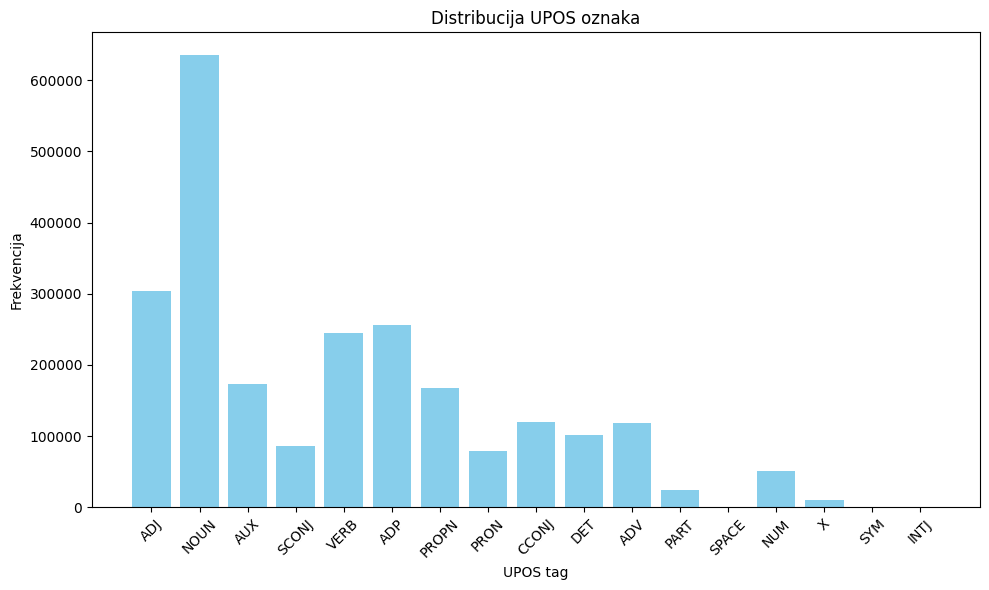

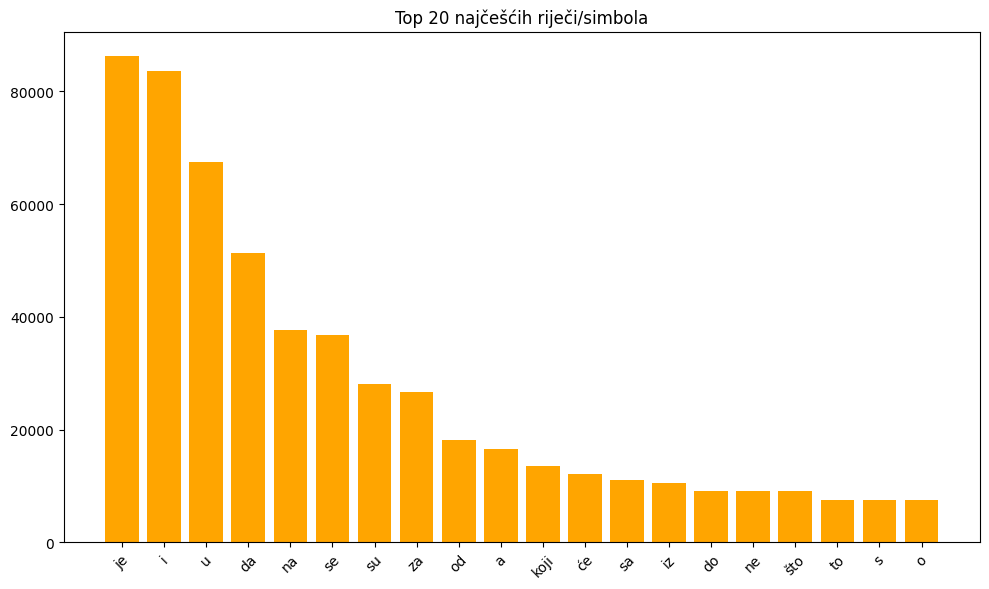

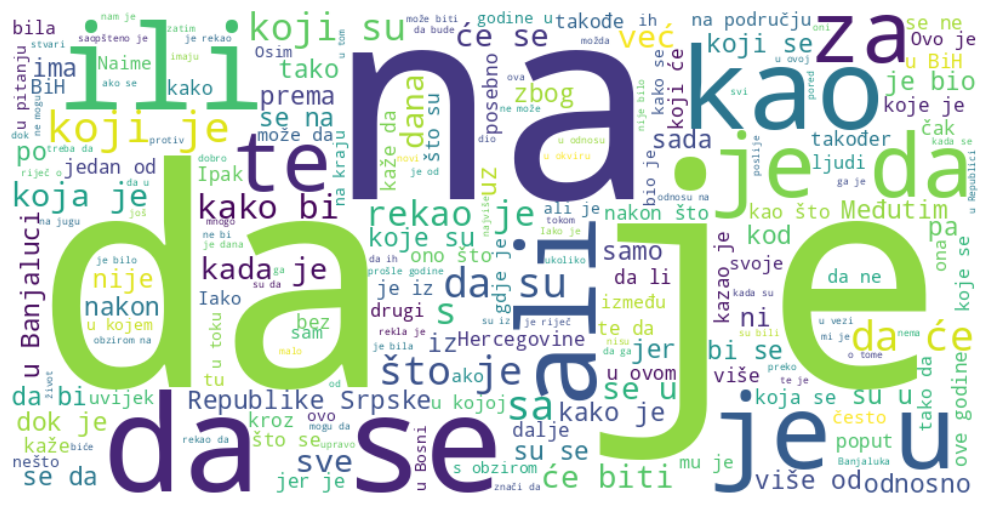

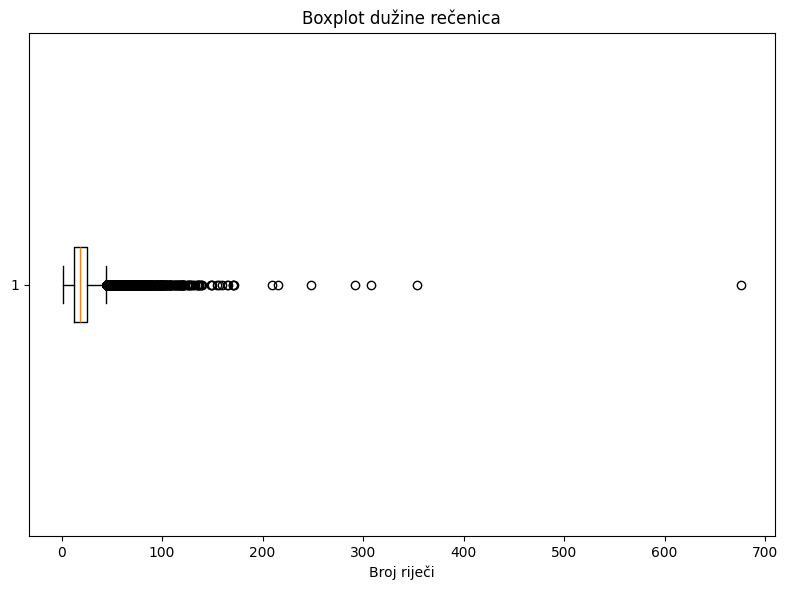

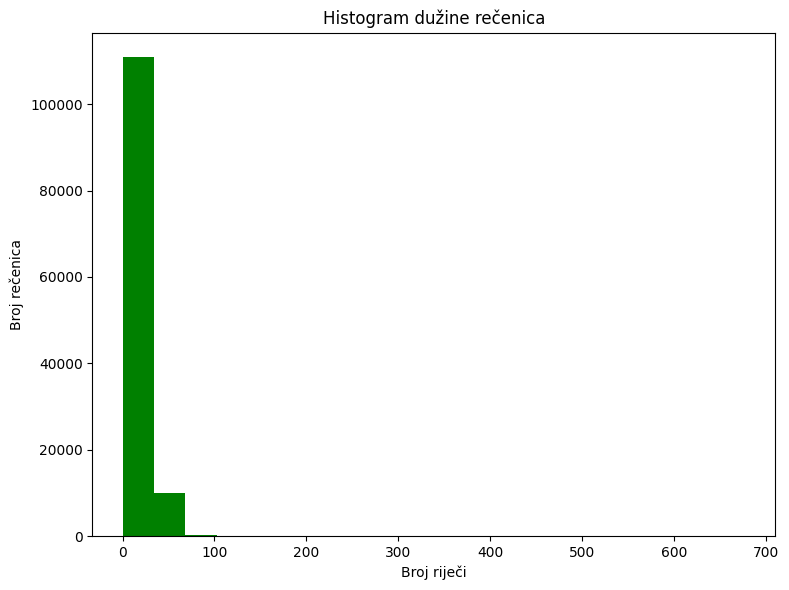

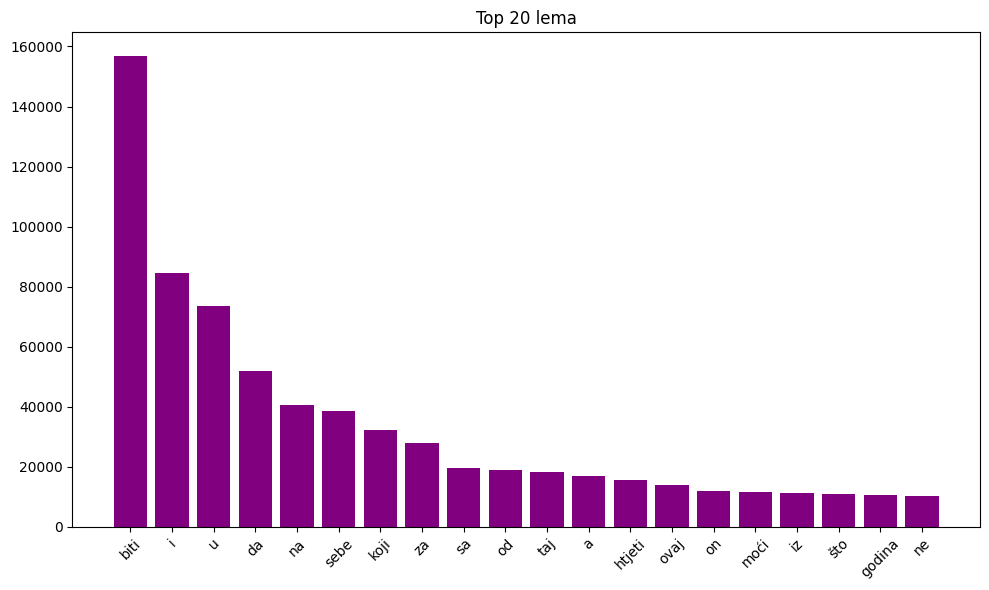

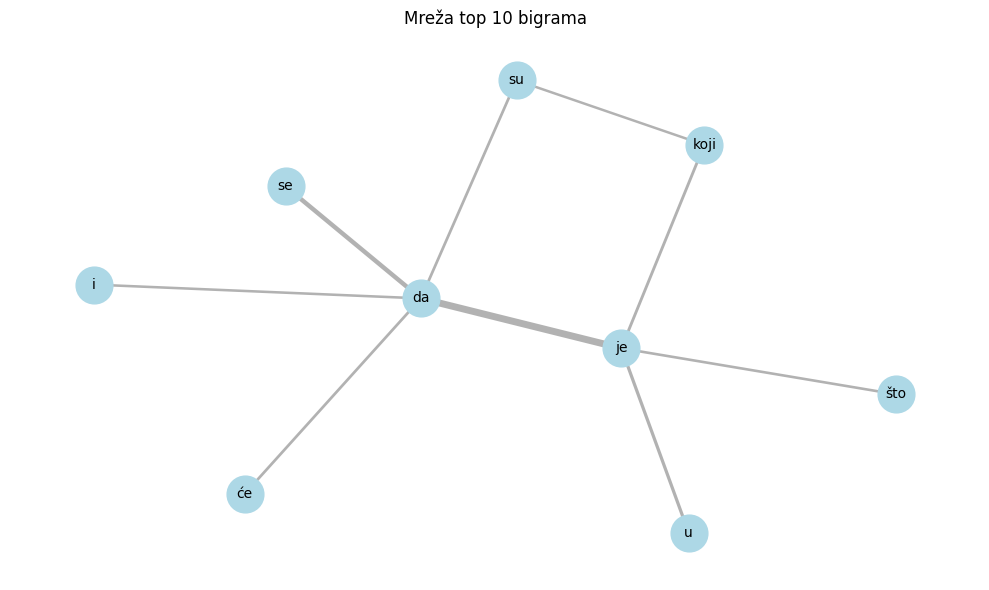

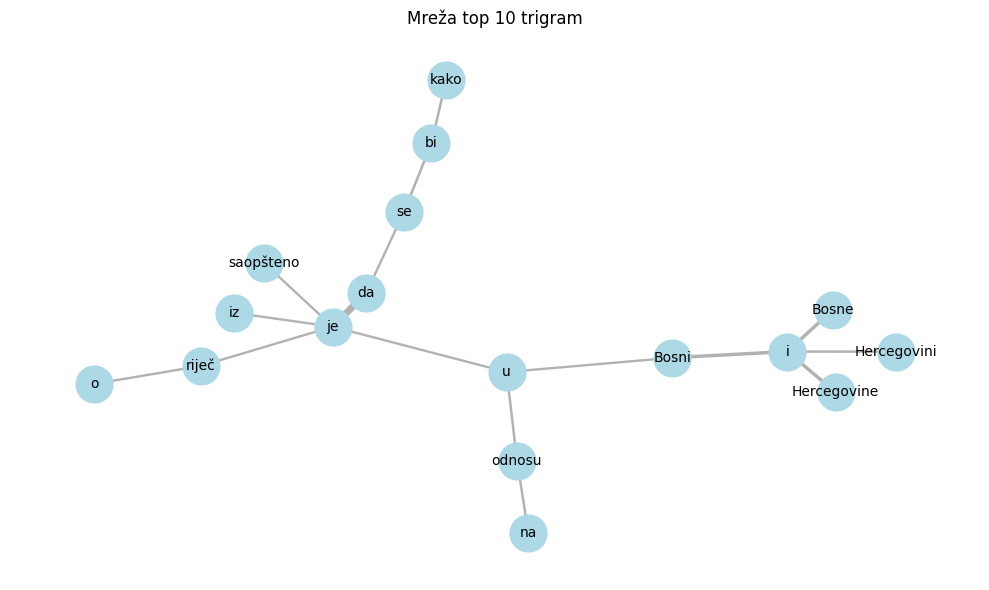

['/content/drive/MyDrive/VI_Projekat_Tim35/images/upos_histogram.png',
 '/content/drive/MyDrive/VI_Projekat_Tim35/images/top_words.png',
 '/content/drive/MyDrive/VI_Projekat_Tim35/images/wordcloud.png',
 '/content/drive/MyDrive/VI_Projekat_Tim35/images/sentence_length_boxplot.png',
 '/content/drive/MyDrive/VI_Projekat_Tim35/images/sentence_length_histogram.png',
 '/content/drive/MyDrive/VI_Projekat_Tim35/images/pca_tfidf.png',
 '/content/drive/MyDrive/VI_Projekat_Tim35/images/top_lemmas.png',
 '/content/drive/MyDrive/VI_Projekat_Tim35/images/word_length_distribution.png',
 '/content/drive/MyDrive/VI_Projekat_Tim35/images/top_bigrams.png',
 '/content/drive/MyDrive/VI_Projekat_Tim35/images/top_trigrams.png']

In [ ]:
import os
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.util import ngrams
from gensim import corpora, models
import networkx as nx

stop_words = {
    'i', 'u', 'je', 'da', 'se', 'na', 'su', 's', 'za', 'od', 'koji',
    'kao', 'po', 'što', 'ali', 'nisu', 'nije', 'biti', 'bi', 'će',
    'sam', 'smo', 'ste', 'ga', 'me', 'te', 'li', 'do', 'iz', 'o', 'već'
}

# Create image folder
os.makedirs('images', exist_ok=True)

# Load and filter from .conllu
file_path = '/content/drive/MyDrive/VI_Projekat_Tim35/BS_TrainingData/Processed_data/bstrainingdata.conllu'

upos_tags = []
words = []
lemmas = []
sentences = []
sentence = []

punctuation_tags = {'PUNCT'}  # UPOS tag for interpunction

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line.startswith('#'):
            continue
        elif not line:
            if sentence:
                sentences.append(sentence)
                sentence = []
            continue
        columns = line.split('\t')
        if len(columns) >= 4:
            word = columns[1]
            lemma = columns[2]
            upos = columns[3]

            # Remove interpunction per POS tag
            if upos not in punctuation_tags:
                upos_tags.append(upos)
                if word not in string.punctuation:
                    words.append(word)
                    lemmas.append(lemma)
                    sentence.append(word)

if sentence:
    sentences.append(sentence)

plt.figure(figsize=(10, 6))
upos_counter = Counter(upos_tags)
plt.bar(upos_counter.keys(), upos_counter.values(), color='skyblue')
plt.title('Distribucija UPOS oznaka')
plt.xlabel('UPOS tag')
plt.ylabel('Frekvencija')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/VI_Projekat_Tim35/images/upos_histogram.png')
plt.show()
plt.close()

word_counter = Counter(words)
most_common_words = word_counter.most_common(20)
labels, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='orange')
plt.title('Top 20 najčešćih riječi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/VI_Projekat_Tim35/images/top_words.png')
plt.show()
plt.close()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/VI_Projekat_Tim35/images/wordcloud.png')
plt.show()
plt.close()

sentence_lengths = [len(s) for s in sentences]
plt.figure(figsize=(8, 6))
plt.boxplot(sentence_lengths, vert=False)
plt.title('Boxplot dužine rečenica')
plt.xlabel('Broj riječi')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/VI_Projekat_Tim35/images/sentence_length_boxplot.png')
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
plt.hist(sentence_lengths, bins=20, color='green')
plt.title('Histogram dužine rečenica')
plt.xlabel('Broj riječi')
plt.ylabel('Broj rečenica')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/VI_Projekat_Tim35/images/sentence_length_histogram.png')
plt.show()
plt.close()

lemma_counter = Counter(lemmas)
most_common_lemmas = lemma_counter.most_common(20)
labels, counts = zip(*most_common_lemmas)

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='purple')
plt.title('Top 20 lema')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/VI_Projekat_Tim35/images/top_lemmas.png')
plt.show()
plt.close()

def draw_ngram_network(ngrams_counter, title, output_path):
    G = nx.Graph()
    top_ngrams = ngrams_counter.most_common(10)

    for ngram, weight in top_ngrams:
        for i in range(len(ngram) - 1):
            u, v = ngram[i], ngram[i+1]
            if G.has_edge(u, v):
                G[u][v]['weight'] += weight
            else:
                G.add_edge(u, v, weight=weight)

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    weights = [G[u][v]['weight'] for u, v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    # Normalize edge width
    max_weight = max(weights) if weights else 1
    norm_weights = [1 + (w / max_weight) * 4 for w in weights]  # width 1–5

    nx.draw_networkx_edges(G, pos, width=norm_weights, alpha=0.6, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    plt.close()

bigrams = Counter()
for s in sentences:
    for bg in ngrams(s, 2):
        bigrams[bg] += 1
draw_ngram_network(bigrams, 'Mreža top 10 bigrama', '/content/drive/MyDrive/VI_Projekat_Tim35/images/top_bigrams.png')

trigrams = Counter()
for s in sentences:
    for tg in ngrams(s, 3):
        trigrams[tg] += 1
draw_ngram_network(trigrams, 'Mreža top 10 trigram', '/content/drive/MyDrive/VI_Projekat_Tim35/images/top_trigrams.png')

# Paths to all saved figures
[
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/upos_histogram.png",
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/top_words.png",
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/wordcloud.png",
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/sentence_length_boxplot.png",
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/sentence_length_histogram.png",
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/pca_tfidf.png",
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/top_lemmas.png",
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/word_length_distribution.png",
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/top_bigrams.png",
    "/content/drive/MyDrive/VI_Projekat_Tim35/images/top_trigrams.png"
]

## Creating a new model with an untrained pipeline

For creating a custom SpaCy model, we need to create an inital config.cfg file with necessary components (pipes) to be able to train the model. Initially, we will use the "hr" language code for Croatian, since there's already a Tokenizer for it, but once the config.cfg file is generated, we will change the lang = "hr" into lang = "bs". The reason for this is that the "hr" code automatically "grabs" the base (untrained) Tokenizer for the Croatian language but once that is done, we can change the language code however we see fit.

In [4]:
!pip install spacy
!pip install spacy[transformers]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.8/758.8 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!python -m spacy init config config.cfg \
  --lang hr \
  --pipeline tok2vec,tagger,ner,morphologizer,parser,lemmatizer,senter,attribute_ruler \
  --optimize accuracy \
  --gpu \
  --force

ℹ Generated config template specific for your use case
- Language: hr
- Pipeline: tagger, ner, morphologizer, parser, lemmatizer, senter,
attribute_ruler
- Optimize for: accuracy
- Hardware: GPU
- Transformer: bert-base-multilingual-uncased
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


Considering that the Croatian language corpus uses custom columns which are currently irrelevant we perform the mapping of the corpus to the .conllu format which is a standardized 10-column format commonly used for storing language corpuses. The mapping is performed by built in Spacy functions for this purpose.

In [ ]:
input_file = "/content/drive/MyDrive/VI_Projekat_Tim35/hr500k.conllup"
output_file = "/content/drive/MyDrive/VI_Projekat_Tim35/hr500k10Columns.conllu"

with open(input_file, "r", encoding="utf-8") as f_in, open(output_file, "w", encoding="utf-8") as f_out:
    for line in f_in:
        if line.startswith("#") or line.strip() == "":
            f_out.write(line)
            continue
        columns = line.strip().split("\t")
        if len(columns) >= 10:
            f_out.write("\t".join(columns[:10]) + "\n")


In [ ]:
!python -m spacy convert /content/drive/MyDrive/VI_Projekat_Tim35/hr500k10Columns.conllu . --lang hr --converter conllu

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (24763 documents): hr500k10Columns.spacy


Next a train and test split of the Croatian language dataset is created.

In [ ]:
import random
import spacy
from spacy.tokens import DocBin

# Load your single .spacy file
input_path = "/content/drive/MyDrive/VI_Projekat_Tim35/hr500k10Columns.spacy"
train_output_path = "/content/drive/MyDrive/VI_Projekat_Tim35/train.spacy"
dev_output_path = "/content/drive/MyDrive/VI_Projekat_Tim35/dev.spacy"

# Load the DocBin
doc_bin = DocBin().from_disk(input_path)
docs = list(doc_bin.get_docs(spacy.blank("bs").vocab))

# Shuffle and split
random.shuffle(docs)
split = int(len(docs) * 0.7)  # 70% train, 30% dev

train_docs = docs[:split]
dev_docs = docs[split:]

# Save new .spacy files
DocBin(docs=train_docs).to_disk(train_output_path)
DocBin(docs=dev_docs).to_disk(dev_output_path)

print(f"Split complete: {len(train_docs)} train docs, {len(dev_docs)} dev docs")


Split complete: 17334 train docs, 7429 dev docs


In [ ]:
!pip install spacy-lookups-data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.4 MB/s eta 0:00:00


Finally the training of the model is performed.

In [ ]:
!python -m spacy train /content/drive/MyDrive/VI_Projekat_Tim35/config.cfg \
  --output /content/drive/MyDrive/VI_Projekat_Tim35/ \
  --paths.train /content/drive/MyDrive/VI_Projekat_Tim35/train.spacy \
  --paths.dev /content/drive/MyDrive/VI_Projekat_Tim35/dev.spacy \
  --gpu-id 0


ℹ Saving to output directory:
/content/drive/MyDrive/VI_Projekat_Tim35
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tagger', 'ner', 'morphologizer', 'parser', 'lemmatizer',
'senter', 'attribute_ruler']
ℹ Initial learn rate: 0.0
E    #       LOSS TAGGER  LOSS NER  LOSS MORPH...  LOSS PARSER  LOSS SENTER  TAG_ACC  POS_ACC  ENTS_F  ENTS_P  ENTS_R  MORPH_ACC  DEP_UAS  DEP_LAS  SENTS_P  SENTS_R  SENTS_F  LEMMA_ACC  SCORE 
---  ------  -----------  --------  -------------  -----------  -----------  -------  -------  ------  ------  ------  ---------  -------  -------  -------  -------  -------  ---------  ------
/usr/local/lib/python3.11/dist-packages/spacy/pipeline/attributeruler.py:137: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.

## Model application

In the end, a short demo of the usage of the model is given below.

In [ ]:
import spacy

In [ ]:
from spacy.tokens import DocBin
from spacy import blank

db = DocBin().from_disk("/content/drive/MyDrive/VI_Projekat_Tim35/HR_Model_Training_Example/train.spacy")
docs = list(db.get_docs(blank("hr").vocab))
# Check first doc
for doc in docs:
  for ent in doc.ents:
      print(ent.text, ent.label_)

In [ ]:
# Load the trained model
nlp = spacy.load("/content/drive/MyDrive/VI_Projekat_Tim35/BS_Model_v2/model-best")

In [ ]:
doc = nlp("Predsjednik Federacije Bosne i Hercegovine održao je govor u Sarajevu. Novi izbori će biti održani narednog mjeseca.")

# Print token info
for token in doc:
    print(f"{token.i+1:2}\t{token.text:<15}\t{token.lemma_:<15}\t{token.pos_:<6}\t{token.dep_:<10}\tHead={token.head.text}")

 1	Predsjednik    	Predsjednik    	NOUN  	nsubj     	Head=održao
 2	Federacije     	Federacije     	NOUN  	nmod      	Head=Predsjednik
 3	Bosne          	Bosne          	PROPN 	compound  	Head=Federacije
 4	i              	i              	CCONJ 	flat      	Head=Bosne
 5	Hercegovine    	Hercegovine    	PROPN 	flat      	Head=Bosne
 6	održao         	održati        	VERB  	ROOT      	Head=održao
 7	je             	biti           	AUX   	aux       	Head=održao
 8	govor          	govor          	NOUN  	obj       	Head=održao
 9	u              	u              	ADP   	case      	Head=Sarajevu
10	Sarajevu       	Sarajevu       	PROPN 	nmod      	Head=govor
11	.              	.              	PUNCT 	punct     	Head=održao
12	Novi           	Novi           	ADJ   	amod      	Head=izbori
13	izbori         	izbor          	NOUN  	nsubj     	Head=održani
14	će             	htjeti         	AUX   	aux       	Head=održani
15	biti           	biti           	AUX   	cop       	Head=održani
16	održani    

/usr/local/lib/python3.11/dist-packages/spacy/pipeline/attributeruler.py:137: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [ ]:
print("\nNamed Entities:")
for ent in doc.ents:
    print(f"{ent.text:<30} {ent.label_}")


Named Entities:
Federacije Bosne i Hercegovine održao ORG
Sarajevu.                      LOC


In [ ]:
from spacy import displacy

displacy.render(doc, style="dep", jupyter=True)  # Dependency parse

In [ ]:
displacy.render(doc, style="ent", jupyter=True)  # NER

In [ ]:
print("Tokenization:")
print([token.text for token in doc])

Tokenization:
['Predsjednik', 'Federacije', 'Bosne', 'i', 'Hercegovine', 'održao', 'je', 'govor', 'u', 'Sarajevu', '.', 'Novi', 'izbori', 'će', 'biti', 'održani', 'narednog', 'mjeseca', '.']


In [ ]:
print("\n POS Tags:")
for token in doc:
    print(f"{token.text:<15} {token.pos_:<6} ({token.tag_})")


 POS Tags:
Predsjednik     NOUN   (Ncmsn)
Federacije      NOUN   (Ncfsg)
Bosne           PROPN  (Npfsg)
i               CCONJ  (Cc)
Hercegovine     PROPN  (Npfsg)
održao          VERB   (Vmp-sm)
je              AUX    (Var3s)
govor           NOUN   (Ncmsn)
u               ADP    (Sl)
Sarajevu        PROPN  (Npnsl)
.               PUNCT  (Z)
Novi            ADJ    (Agpmpny)
izbori          NOUN   (Ncmpn)
će              AUX    (Var3s)
biti            AUX    (Van)
održani         ADJ    (Appmpny)
narednog        ADJ    (Agpmsgy)
mjeseca         NOUN   (Ncmsg)
.               PUNCT  (Z)


In [ ]:
print("\nMorphological Features:")
for token in doc:
    print(f"{token.text:<15} {token.morph}")


Morphological Features:
Predsjednik     Case=Nom|Gender=Masc|Number=Sing
Federacije      Case=Gen|Gender=Fem|Number=Sing
Bosne           Case=Gen|Gender=Fem|Number=Sing
i               
Hercegovine     Case=Gen|Gender=Fem|Number=Sing
održao          Gender=Masc|Number=Sing|Tense=Past|VerbForm=Part|Voice=Act
je              Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin
govor           Case=Nom|Gender=Masc|Number=Sing
u               Case=Loc
Sarajevu        Case=Loc|Gender=Neut|Number=Sing
.               
Novi            Case=Nom|Definite=Def|Degree=Pos|Gender=Masc|Number=Sing
izbori          Case=Nom|Gender=Masc|Number=Plur
će              Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin
biti            VerbForm=Inf
održani         Case=Nom|Definite=Def|Degree=Pos|Gender=Masc|Number=Plur
narednog        Case=Gen|Definite=Def|Degree=Pos|Gender=Masc|Number=Sing
mjeseca         Case=Gen|Gender=Masc|Number=Sing
.               


In [ ]:
print("\nDependency Parse:")
for token in doc:
    print(f"{token.text:<15} Head: {token.head.text:<15} Dep: {token.dep_}")


Dependency Parse:
Predsjednik     Head: održao          Dep: nsubj
Federacije      Head: Predsjednik     Dep: nmod
Bosne           Head: Federacije      Dep: compound
i               Head: Bosne           Dep: flat
Hercegovine     Head: Bosne           Dep: flat
održao          Head: održao          Dep: ROOT
je              Head: održao          Dep: aux
govor           Head: održao          Dep: obj
u               Head: Sarajevu        Dep: case
Sarajevu        Head: govor           Dep: nmod
.               Head: održao          Dep: punct
Novi            Head: izbori          Dep: amod
izbori          Head: održani         Dep: nsubj
će              Head: održani         Dep: aux
biti            Head: održani         Dep: cop
održani         Head: održao          Dep: conj
narednog        Head: mjeseca         Dep: amod
mjeseca         Head: održani         Dep: obl
.               Head: održao          Dep: punct


In [ ]:
print("\n Lemmas:")
for token in doc:
    print(f"{token.text:<15} → {token.lemma_}")


 Lemmas:
Predsjednik     → Predsjednik
Federacije      → Federacije
Bosne           → Bosne
i               → i
Hercegovine     → Hercegovine
održao          → održati
je              → biti
govor           → govor
u               → u
Sarajevu        → Sarajevu
.               → .
Novi            → Novi
izbori          → izbor
će              → htjeti
biti            → biti
održani         → održati
narednog        → naredan
mjeseca         → mjesec
.               → .


In [ ]:
print("\n Sentences:")
for sent in doc.sents:
    print(sent.text)


 Sentences:
Predsjednik Federacije Bosne i Hercegovine održao je govor u Sarajevu. Novi izbori će biti održani narednog mjeseca.


In [ ]:
print("\n Attribute Ruler Exists?")
print("attribute_ruler" in nlp.pipe_names)


 Attribute Ruler Exists?
True


In [ ]:
ruler = nlp.get_pipe("attribute_ruler")
print("\nExample rules (if any):", ruler)


Example rules (if any): <spacy.pipeline.attributeruler.AttributeRuler object at 0x79a4be9fe4d0>


In [ ]:
print("\n Named Entities:")
for ent in doc.ents:
    print(f"{ent.text:<30} {ent.label_}")


 Named Entities:
Federacije Bosne i Hercegovine održao ORG
Sarajevu.                      LOC


In [ ]:
print("\n Pipeline components:")
print(nlp.pipe_names)


 Pipeline components:
['tagger', 'ner', 'morphologizer', 'parser', 'lemmatizer', 'senter', 'attribute_ruler']


After the demo the model is packaged for future use

In [ ]:
!mkdir -p /content/drive/MyDrive/VI_Projekat_Tim35/packages

In [ ]:
!python -m spacy package /content/drive/MyDrive/VI_Projekat_Tim35/BS_Model_v2/model-best /content/drive/MyDrive/VI_Projekat_Tim35/packages --name bosanski_model --version 0.0.1

/usr/local/lib/python3.11/dist-packages/click/core.py:1193: UserWarning: The parameter -R is used more than once. Remove its duplicate as parameters should be unique.
  parser = self.make_parser(ctx)
/usr/local/lib/python3.11/dist-packages/click/core.py:1186: UserWarning: The parameter -R is used more than once. Remove its duplicate as parameters should be unique.
  self.parse_args(ctx, args)
ℹ Building package artifacts: sdist
✔ Including 1 package requirement(s) from meta and config
spacy>=3.8.7,<3.9.0
✔ Loaded meta.json from file
/content/drive/MyDrive/VI_Projekat_Tim35/BS_Model_v2/model-best/meta.json
✔ Generated README.md from meta.json
✔ Successfully created package directory 'hr_bosanski_model-0.0.1'
/content/drive/MyDrive/VI_Projekat_Tim35/packages/hr_bosanski_model-0.0.1
* Creating isolated environment: venv+pip...
* Installing packages in isolated environment:
  - setuptools >= 40.8.0
* Getting build dependencies for sdist...
running egg_info
creating hr_bosanski_model.egg-in

In [ ]:
!pip install /content/drive/MyDrive/VI_Projekat_Tim35/packages/hr_bosanski_model-0.0.1/dist/hr_bosanski_model-0.0.1.tar.gz

Processing ./drive/MyDrive/VI_Projekat_Tim35/packages/hr_bosanski_model-0.0.1/dist/hr_bosanski_model-0.0.1.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for hr_bosanski_model: filename=hr_bosanski_model-0.0.1-py3-none-any.whl size=23012433 sha256=9d0cda9ee6b81732b6d66b06ed735425d776a805863453f88c1eafd1255baca4
  Stored in directory: /root/.cache/pip/wheels/b1/39/57/65ab2ae345024790b15e02bbd3053a008b9aa63879c1581f53
Successfully built hr_bosanski_model


Now the model can be used out of the box

In [ ]:
import spacy
nlp = spacy.load("hr_bosanski_model")

In [ ]:
doc = nlp("Predsjednik Federacije Bosne i Hercegovine održao je govor u Sarajevu. Novi izbori će biti održani narednog mjeseca.")

# Print token info
for token in doc:
    print(f"{token.i+1:2}\t{token.text:<15}\t{token.lemma_:<15}\t{token.pos_:<6}\t{token.dep_:<10}\tHead={token.head.text}")

 1	Predsjednik    	Predsjednik    	NOUN  	nsubj     	Head=održao
 2	Federacije     	Federacije     	NOUN  	nmod      	Head=Predsjednik
 3	Bosne          	Bosne          	PROPN 	compound  	Head=Federacije
 4	i              	i              	CCONJ 	flat      	Head=Bosne
 5	Hercegovine    	Hercegovine    	PROPN 	flat      	Head=Bosne
 6	održao         	održati        	VERB  	ROOT      	Head=održao
 7	je             	biti           	AUX   	aux       	Head=održao
 8	govor          	govor          	NOUN  	obj       	Head=održao
 9	u              	u              	ADP   	case      	Head=Sarajevu
10	Sarajevu       	Sarajevu       	PROPN 	nmod      	Head=govor
11	.              	.              	PUNCT 	punct     	Head=održao
12	Novi           	Novi           	ADJ   	amod      	Head=izbori
13	izbori         	izbor          	NOUN  	nsubj     	Head=održani
14	će             	htjeti         	AUX   	aux       	Head=održani
15	biti           	biti           	AUX   	cop       	Head=održani
16	održani    

/usr/local/lib/python3.11/dist-packages/spacy/pipeline/attributeruler.py:137: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


## Model application

For a better user experience, a UI for applying the model is created:

In [ ]:
!pip install --upgrade gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.10.1
    Uninstalling gradio_client-1.10.1:
      Successfully uninstalled gradio_client-1.10.1
  Attempting uninstall: gradio
    Found existing installation: gradio 5.31.0
    Uninstalling gradio-5.31.0:


In [ ]:
import spacy
import gradio as gr
from spacy import displacy

nlp = spacy.load("drive/MyDrive/VI_Projekat_Tim35/BS_Model_v2/model-best")

def analyze(text):
    doc = nlp(text)
    # Visual NER as HTML
    ner_html = displacy.render(doc, style="ent", jupyter=False)

    # POS & Lemma Table
    pos_table = [(token.text, token.pos_, token.lemma_) for token in doc]

    return ner_html, pos_table

iface = gr.Interface(
    fn=analyze,
    inputs=gr.Textbox(lines=3, label="Unesi rečenicu"),
    outputs=[
        gr.HTML(label="Prepoznati entiteti (vizualno)"),
        gr.Dataframe(headers=["Token", "POS", "Lemma"])
    ],
    title="Bosanski NLP Analizator",
    description="Unesi rečenicu na bosanskom jeziku kako bi se prikazali entiteti i lingvističke informacije."
)

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://81dc65e3e6ee958832.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
